# Ensamble de modelos

Los ensambles de modelos, como su nombre lo indica, son una técnica de construcción de modelos de clasificación o regresión, en la que el  modelo generado es una agrupación de varios modelos, que se usan en conjunto para obtener la mejor predicción posible. 

La predicción realizada en un ensamble se realiza teniendo en cuenta a cada uno de los modelos que componen al ensamble, es decir, se toma en cuenta la clasificación o regresión realizada por cada uno de estos. Cómo se determine el resultado final depende del tipo de modelo de ensamble. 

Existen distintos tipos de ensambles:

1-Homogéneos: Cuando el ensamble está formado por modelos del mismo tipo.

2-Híbridos: Cuando el ensamble está formado por modelos de distinto tipo.

Para los objetivos del trabajo interesa construir modelos de ensamble híbridos. Se construirán 2 modelos de ensamble; Uno de tipo Voting, y otro de tipo Stacking. 

En primer lugar importamos las librerías que utilizaremos

In [1]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline
import pickle
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

Importamos los datasets que utilizaremos

In [2]:
train = pd.read_csv("datasets/ds_con_tipo_precio_train.csv")
test = pd.read_csv("datasets/ds_con_tipo_precio_test.csv")
train.drop(columns="Unnamed: 0", inplace=True)
test.drop(columns="Unnamed: 0", inplace=True)

In [3]:
train.head()

,created_on,latitud,longitud,provincia,barrio,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,precio_metro_cuadrado,tipo_precio
0,2021-03-10,-34.611523,-58.410394,Capital Federal,BALVANERA,Venta,Departamento,1.0,1.0,49.0,45.0,79000.0,USD,1612.244898,bajo
1,2021-04-16,-34.621782,-58.424452,Capital Federal,ALMAGRO,Venta,Departamento,1.0,1.0,44.0,40.0,99000.0,USD,2250.000000,medio
2,2021-08-28,-34.592425,-58.515042,Capital Federal,VILLA DEVOTO,Venta,PH,3.0,2.0,76.0,66.0,160000.0,USD,2105.263158,alto
3,2021-11-29,-34.607836,-58.446965,Capital Federal,CABALLITO,Venta,Departamento,2.0,1.0,56.0,50.0,153000.0,USD,2732.142857,alto
4,2021-12-17,-34.561456,-58.467606,Capital Federal,BELGRANO,Venta,Departamento,2.0,1.0,55.0,45.0,159000.0,USD,2890.909091,alto


In [4]:
test.head()

,created_on,latitud,longitud,provincia,barrio,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,precio_metro_cuadrado,tipo_precio
0,2021-11-09,-34.552834,-58.491372,Capital Federal,SAAVEDRA,Venta,PH,5.0,3.0,158.000000,115.0,220000.0,USD,1392.405063,medio
1,2021-03-23,-34.580101,-58.412473,Capital Federal,PALERMO,Venta,PH,2.0,1.0,35.000000,32.0,90000.0,USD,2571.428571,alto
2,2021-10-05,-34.598510,-58.411857,Capital Federal,ABASTO,Venta,Departamento,2.0,1.0,43.000000,41.0,85000.0,USD,1976.744186,bajo
3,2021-05-15,-34.567515,-58.458584,Capital Federal,BELGRANO,Venta,Departamento,2.0,1.0,111.325111,44.0,144000.0,USD,1293.508708,bajo
4,2021-09-02,-34.588866,-58.416343,Capital Federal,PALERMO,Venta,Departamento,2.0,1.0,39.000000,36.0,105000.0,USD,2692.307692,alto


## Ensamble 1: Voting

Partiendo del conjunto de datos de clasificación se construirá un modelo de tipo voting, en donde se construyen N modelos (siendo al menos uno de ellos distinto a los demás) usando los mismos de datos  del conjunto de datos. Cada modelo realiza una clasificación, el resultado final es la predicción mayoritaria entre los N modelos que forman parte del ensamble generado, de ahí el nombre "Voting".

En primer lugar importamos las librerías de los clasificadores que utilizaremos para el ensamble

In [5]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score

Se eliminan aquellas columnas del dataset que contengan variables categóricas de único valor. Estas son, la provincia (Capital Federal), el tipo de operación (venta), la moneda (USD). Al ser variables con un único valor (no analizamos otras en este tp) no aportan información relevante.
Por otro lado, se realiza One Hot Encoding a las variables categóricas que sí interesan para clasificar.
Sacamos las variables de precio y pxm2 para evitar el data leakage.

In [6]:
#separo en x e y
x_train = train.drop(columns="tipo_precio", inplace=False)
y_train = train.tipo_precio
x_test = test.drop(columns="tipo_precio", inplace=False)
y_test = test.tipo_precio

#acomodo los datos
x_train.drop(columns=['created_on', 'property_currency', 'operation', 'provincia', 'property_price', 'precio_metro_cuadrado'], inplace=True)
x_test.drop(columns=['created_on', 'property_currency', 'operation', 'provincia','property_price', 'precio_metro_cuadrado'], inplace=True)
x_train = pd.get_dummies(x_train, columns=['property_type', 'barrio'])
x_test = pd.get_dummies(x_test, columns=['property_type', 'barrio'])

In [7]:
x_train.shape

(39719, 67)

En vez de entrenar nuevos modelos clasificadores vamos a hacer uso de los ya entrenados en el trabajo práctico Los importamos:

El tamaño en columnas del dataset actual es el mismo con el que fueron entrenados los modelos en en el tp1, además de ser las mismas features, por lo que no los reentrenamos.

In [8]:
d_tree = pickle.load(open('models/arbol_decision.sav', 'rb'))
r_tree = pickle.load(open('models/random_forest.sav', 'rb'))
knn_clasif = pickle.load(open('models/knn_clasificacion.sav', 'rb'))

In [9]:
display(d_tree)
display(r_tree)
display(knn_clasif)

DecisionTreeClassifier(ccp_alpha=0.0003, criterion='entropy',
                       min_samples_leaf=5, min_samples_split=6, random_state=2)

RandomForestClassifier(criterion='entropy', max_features='auto',
                       min_samples_split=14, n_estimators=15, n_jobs=-1,
                       oob_score=True, random_state=2)

KNeighborsClassifier()

Creamos el ensamble de Votación

In [10]:
vot_clf = VotingClassifier(estimators = [('dcs', d_tree), ('rnd', r_tree), ('knn', knn_clasif)], voting = 'hard')

El clasificador de votaciones tiene dos hiperparámetros básicos: estimadores y votaciones.

Estimators: crea una lista de los clasificadores y les asigna nombres
Votación: Se puede establecer en hard o soft. Hard para las ocasiones que el clasificador usa las etiquetas de clase predichas para la votación por regla de la mayoría. Soft utilizará un enfoque ponderado para tomar la decisión (predice en función del argmax de las sumas de las probabilidades predichas).

En este caso establecimos el voting en hard.

Entrenamos el ensamble

In [11]:
vot_clf.fit(x_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


VotingClassifier(estimators=[('dcs',
                              DecisionTreeClassifier(ccp_alpha=0.0003,
                                                     criterion='entropy',
                                                     min_samples_leaf=5,
                                                     min_samples_split=6,
                                                     random_state=2)),
                             ('rnd',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='auto',
                                                     min_samples_split=14,
                                                     n_estimators=15, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=2)),
                             ('knn', KNeighborsClassifier())])

Mostramos las métricas obtenidas y comparamos los resultados obtenidos en train y test:

In [12]:
pred_train = vot_clf.predict(x_train)

              precision    recall  f1-score   support

        alto       0.75      0.88      0.81     13237
        bajo       0.84      0.83      0.84     13481
       medio       0.79      0.66      0.72     13001

    accuracy                           0.79     39719
   macro avg       0.79      0.79      0.79     39719
weighted avg       0.79      0.79      0.79     39719

F1-Score: 0.7914600065459856


Text(50.722222222222214, 0.5, 'True')

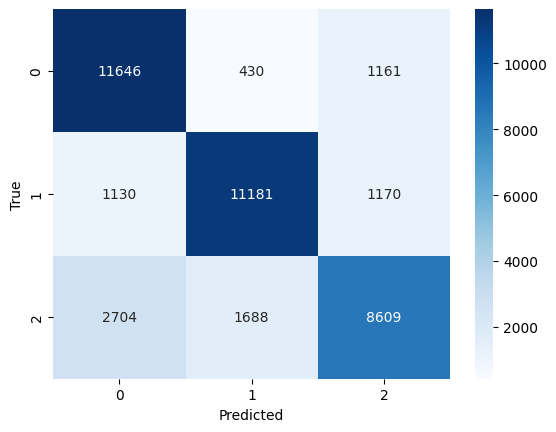

In [13]:
# Reporte de Clasificación sobre train
print(classification_report(y_train,pred_train))
print('F1-Score: {}'.format(f1_score(y_train, pred_train, average='micro')))

# Matriz de Confusión
cm = confusion_matrix(y_train,pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Evaluamos en el conjunto de test

              precision    recall  f1-score   support

        alto       0.65      0.79      0.71      3294
        bajo       0.75      0.73      0.74      3405
       medio       0.60      0.48      0.53      3167

    accuracy                           0.67      9866
   macro avg       0.67      0.67      0.66      9866
weighted avg       0.67      0.67      0.67      9866

F1-Score: 0.6718021487938374


Text(50.722222222222214, 0.5, 'True')

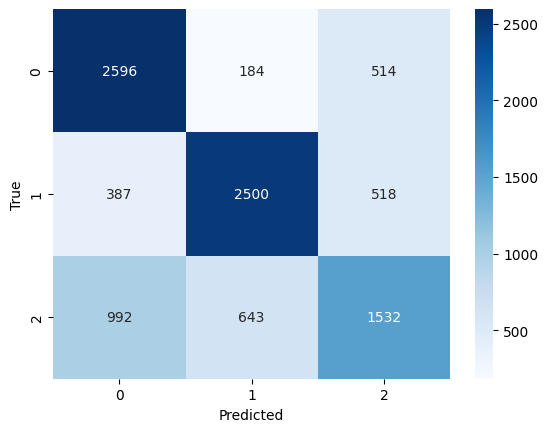

In [14]:
pred_test = vot_clf.predict(x_test)

# Reporte de Clasificación sobre test
print(classification_report(y_test,pred_test))
print('F1-Score: {}'.format(f1_score(y_test, pred_test, average='micro')))

# Matriz de Confusión
cm = confusion_matrix(y_test,pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Vamos a probar lo mismo pero usando 'soft' como mecanismo de voto a ver qué resultados obtenemos.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
              precision    recall  f1-score   support

        alto       0.80      0.86      0.83     13237
        bajo       0.83      0.85      0.84     13481
       medio       0.77      0.70      0.73     13001

    accuracy                           0.80     39719
   macro avg       0.80      0.80      0.80     39719
weighted avg       0.80      0.80      0.80     39719

F1-Score: 0.8025378282434099

Text(50.722222222222214, 0.5, 'True')

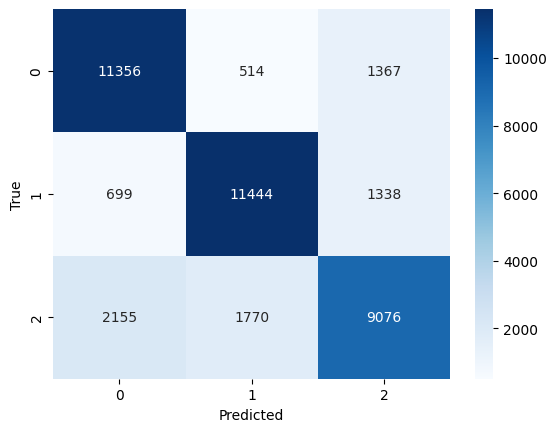

In [15]:
vot_clf2 = VotingClassifier(estimators = [('dcs', d_tree), ('rnd', r_tree), ('knn', knn_clasif)], voting = 'soft')
vot_clf2.fit(x_train, y_train)
pred_train2 = vot_clf2.predict(x_train)

# Reporte de Clasificación sobre train
print(classification_report(y_train,pred_train2))
print('F1-Score: {}'.format(f1_score(y_train, pred_train2, average='micro')))
# Matriz de Confusión
cm = confusion_matrix(y_train,pred_train2)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

              precision    recall  f1-score   support

        alto       0.69      0.76      0.72      3294
        bajo       0.74      0.75      0.74      3405
       medio       0.58      0.52      0.55      3167

    accuracy                           0.68      9866
   macro avg       0.67      0.67      0.67      9866
weighted avg       0.67      0.68      0.67      9866

F1-Score: 0.6774782079870262


Text(50.722222222222214, 0.5, 'True')

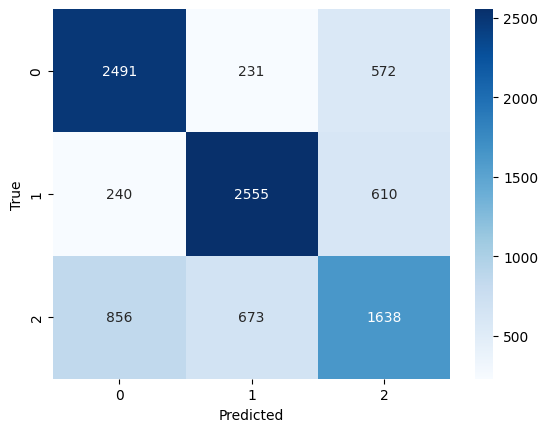

In [16]:
#sobre test
pred_test2 = vot_clf2.predict(x_test)

# Reporte de Clasificación sobre train
print(classification_report(y_test,pred_test2))
print('F1-Score: {}'.format(f1_score(y_test, pred_test2, average='micro')))
# Matriz de Confusión
cm = confusion_matrix(y_test,pred_test2)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Elegimos quedarnos con el modelo 2 dado que si bien son muy similares, predice un poco mejor a la clase 'medio'.

Comparación con los modelos del tp1: Si bien esperábamos obtener mejores métricas que los modelos por separado, los resultados fueron similares en este caso. En el tp1 habíamos logrado como mejor f1-score 0.68 (random forest) vs 0.67 usando ensambles.

In [17]:
#Exportamos el modelo
voting = 'models/voting.sav'
pickle.dump(vot_clf2, open(voting, 'wb'))

Entrenamos el modelo sobre el dataset reducido por PCA del tp1 el cual no tuvo en cuenta la variable precio para reducir su dimensionalidad.


In [18]:
reducido_train = pd.read_csv("datasets/dataset_reducido_sin_price.csv")
reducido_test =  pd.read_csv("datasets/dataset_reducido_sin_price_test.csv")
reducido_train.drop(columns="Unnamed: 0", inplace=True)
reducido_test.drop(columns="Unnamed: 0", inplace=True)

In [19]:
voting_model_pca = vot_clf2.fit(reducido_train, y_train)
y_pred_train_pca = voting_model_pca.predict(reducido_train)
y_pred_test_pca = voting_model_pca.predict(reducido_test) 

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


              precision    recall  f1-score   support

        alto       0.79      0.82      0.80     13237
        bajo       0.78      0.82      0.80     13481
       medio       0.76      0.69      0.72     13001

    accuracy                           0.78     39719
   macro avg       0.78      0.78      0.78     39719
weighted avg       0.78      0.78      0.78     39719



Text(50.722222222222214, 0.5, 'True')

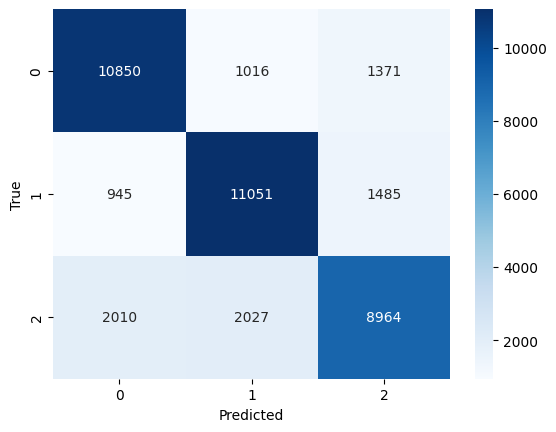

In [20]:
# Reporte de Clasificación sobre train
print(classification_report(y_train,y_pred_train_pca))

# Matriz de Confusión
cm = confusion_matrix(y_train,y_pred_train_pca)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

              precision    recall  f1-score   support

        alto       0.67      0.70      0.69      3294
        bajo       0.67      0.70      0.68      3405
       medio       0.54      0.50      0.52      3167

    accuracy                           0.64      9866
   macro avg       0.63      0.63      0.63      9866
weighted avg       0.63      0.64      0.63      9866



Text(50.722222222222214, 0.5, 'True')

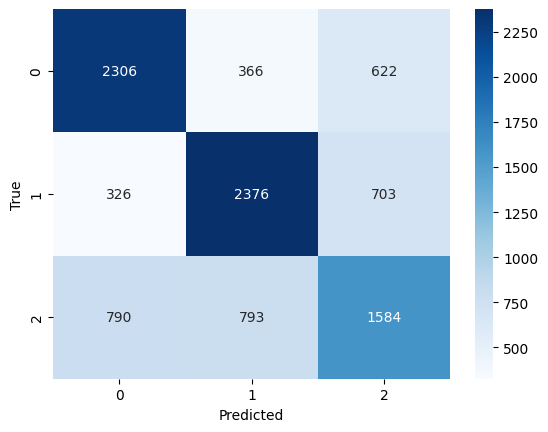

In [21]:
# Reporte de Clasificación sobre test
print(classification_report(y_test,y_pred_test_pca))

# Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_test_pca)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [22]:
#Exportamos el modelo
voting = 'models/voting_reducido.sav'
pickle.dump(voting_model_pca, open(voting, 'wb'))

Luego de haber hecho en el tp1 este mismo entrenamiento de todos los modelos sobre los ds reducidos, era de esperarse que los resultados fueran similares a los arrojados por el dataset sin reducir. Son un poco más bajas sus métricas pero no hay una diferencia muy significativa. Esto resulta altamente ventajoso dado que al trabajar con datasets muy grandes, podemos "achicarlos" sin perder información relevante.

## Ensamble 2: Stacking

Un ensamble de tipo stacking, entrena diferentes modelos base, con un modelo adicional que decide cual de todo los modelos base usar. Esto último es un reemplazo a la técnica de voting a través del concepto de meta-aprendizaje. 

Para el ensamble armado, se hará uso de distintos modelos de regresión junto a un modelo adicional para estimar el valor final. 

Para los modelos base elegimos Random Forest, SVM y K Neighbors. Para el modelo adicional, un árbol de decisión.  Dicho modelo adicional actuara sobre los modelos bases y nos dara una eleccion final sobre ellos

Importamos las librerias

In [24]:
!pip install xgboost==1.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 8.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [25]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
import xgboost as xgb
from sklearn import tree
from sklearn import svm
import sklearn
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Separamos el target que es el precio de la propiedad, utilizamos dummies en las categorias de property type y barrio para poder predecir mejor y no perder informacion. Por ultimo droppeamos algunas categorias que no aportan valor a la prediccion, como tambien la variable a predecir.

In [26]:
train = pd.read_csv("datasets/ds_con_tipo_precio_train.csv")
test = pd.read_csv("datasets/ds_con_tipo_precio_test.csv")
train.drop(columns="Unnamed: 0", inplace=True)
test.drop(columns="Unnamed: 0", inplace=True)

x_train = train.drop(columns="property_price", inplace=False)
y_train = train.property_price
x_test = test.drop(columns="property_price", inplace=False)
y_test = test.property_price

#acomodo los datos
x_train.drop(columns=['created_on', 'property_currency', 'operation', 'provincia', 'precio_metro_cuadrado'], inplace=True)
x_test.drop(columns=['created_on', 'property_currency', 'operation', 'provincia', 'precio_metro_cuadrado'], inplace=True)

x_train.drop(columns=['tipo_precio'],inplace=True)
x_test.drop(columns=['tipo_precio'],inplace=True)

x_train = pd.get_dummies(x_train, columns=['property_type', 'barrio'])
x_test = pd.get_dummies(x_test, columns=['property_type', 'barrio'])

In [27]:
display(x_train)
display(y_train)
display(x_test)
display(y_test)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH,barrio_ABASTO,...,barrio_VILLA GENERAL MITRE,barrio_VILLA LUGANO,barrio_VILLA LURO,barrio_VILLA ORTUZAR,barrio_VILLA PUEYRREDÓN,barrio_VILLA REAL,barrio_VILLA RIACHUELO,barrio_VILLA SANTA RITA,barrio_VILLA SOLDATI,barrio_VILLA URQUIZA
0,-34.611523,-58.410394,1.0,1.0,49.0,45.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.621782,-58.424452,1.0,1.0,44.0,40.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.592425,-58.515042,3.0,2.0,76.0,66.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-34.607836,-58.446965,2.0,1.0,56.0,50.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-34.561456,-58.467606,2.0,1.0,55.0,45.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39714,-34.571366,-58.432307,2.0,1.0,37.0,37.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39715,-34.549300,-58.451028,2.0,1.0,89.0,36.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39716,-34.578044,-58.499339,5.0,3.0,340.0,276.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
39717,-34.625708,-58.418858,2.0,1.0,64.0,47.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


0         79000.0
1         99000.0
2        160000.0
3        153000.0
4        159000.0
           ...   
39714    126900.0
39715    185000.0
39716    795000.0
39717    125000.0
39718     77000.0
Name: property_price, Length: 39719, dtype: float64

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH,barrio_ABASTO,...,barrio_VILLA GENERAL MITRE,barrio_VILLA LUGANO,barrio_VILLA LURO,barrio_VILLA ORTUZAR,barrio_VILLA PUEYRREDÓN,barrio_VILLA REAL,barrio_VILLA RIACHUELO,barrio_VILLA SANTA RITA,barrio_VILLA SOLDATI,barrio_VILLA URQUIZA
0,-34.552834,-58.491372,5.0,3.0,158.000000,115.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.580101,-58.412473,2.0,1.0,35.000000,32.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.598510,-58.411857,2.0,1.0,43.000000,41.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-34.567515,-58.458584,2.0,1.0,111.325111,44.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-34.588866,-58.416343,2.0,1.0,39.000000,36.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9861,-34.605292,-58.424336,1.0,1.0,42.000000,40.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9862,-34.615043,-58.508974,4.0,3.0,149.000000,95.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9863,-34.597612,-58.419316,2.0,1.0,53.000000,49.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9864,-34.574036,-58.447151,3.0,2.0,80.000000,80.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


0       220000.0
1        90000.0
2        85000.0
3       144000.0
4       105000.0
          ...   
9861     85000.0
9862    275000.0
9863    143900.0
9864    139500.0
9865    300000.0
Name: property_price, Length: 9866, dtype: float64

Importamos los modelos realizados en el tp1:

In [28]:
xgb = xgb.XGBRegressor()
xgb.load_model("models/xgb.json")
gb = pickle.load(open('models/gb.sav', 'rb'))
knn = pickle.load(open('models/knn_regresion.sav', 'rb'))

A partir de los modelos importados del tp1 tenemos que ver si predicen bien las variables con los hiperparametros utilizados en el tp1, sino encontramos los mejores

In [29]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=-1, nthread=-1,
             num_parallel_tree=1, ...)

In [30]:
y_pred_train=xgb.predict(x_train)

In [31]:
y_pred_test=xgb.predict(x_test)

In [32]:
print("Score de training: ", xgb.score(x_train, y_train) )
print("Score de test: ", xgb.score(x_test,y_test))
print("MSE train: %.2f", mean_squared_error(y_train, y_pred_train))
print("RMSE train: %.2f" % (mean_squared_error(y_train, y_pred_train)**(1/2.0)))
print("MSE test: %.2f" % mean_squared_error(y_test, y_pred_test))
print("RMSE test: %.2f" % (mean_squared_error(y_test, y_pred_test)**(1/2.0)))

Score de training:  0.8949305321679442
Score de test:  0.8397094473623902
MSE train: %.2f 792005860.1433142
RMSE train: 28142.60
MSE test: 1160009377.22
RMSE test: 34058.91


Podemos ver que el root mean squared error nos dio bastante chico, podriamos usar estos hiperparametros ya que tiene una gran capacidad de prediccion en el conjunto de training. Es por ello que para XGboost mantenemos los mismos hiperparametros utilizados en el TP1.

Ahora para gradient boost

In [33]:
gb.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.227, max_depth=5, n_estimators=145,
                          random_state=2)

In [34]:
# R² en train
print("Score de train: %.3f" % gb.score(x_train, y_train))
mse = mean_squared_error(y_train, gb.predict(x_train))
print("El RMSE para el conjunto de train es: ",(mse**(1/2)))

Score de train: 0.903
El RMSE para el conjunto de train es:  27024.04503511355


In [35]:
# R² en train
print("Score de test: %.3f" % gb.score(x_test, y_test))
mse = mean_squared_error(y_test, gb.predict(x_test))
print("El RMSE para el conjunto de test es: ",(mse**(1/2)))

Score de test: 0.840
El RMSE para el conjunto de test es:  34037.22740324443


Otra vez tenemos una buena prediccion con un promedio de 27 mil dolares de error para la prediccion del conjunto de train y de 34 mil dolares de error para el conjutno de test. Consideramos que no es un error grosero, por lo que no buscamos nuevos hiperparametros para gradient boost.

Por ultimo para knn

In [36]:
knn.fit(x_train,y_train) 

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

In [37]:
y_pred_train=xgb.predict(x_train)
y_pred_test=xgb.predict(x_test)

In [38]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = False
       )

print(f"El error (rmse) de train es: {rmse}")

#Coef. de Determinación R2
score_knn = knn.score(x_train, y_train)

print("El score de train es de: ",score_knn)

El error (mse) de train es: 792005860.1433142
El error (rmse) de train es: 28142.5986743107
El score de train es de:  0.99707738158081


In [39]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_test,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_test,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

#Coef. de Determinación R2
score_knn = knn.score(x_test, y_test)

print("El score de test es de: ",score_knn)

El error (mse) de test es: 1160009377.221049
El error (rmse) de test es: 34058.910393919665
El score de test es de:  0.7914238094785705


In [40]:
display(xgb)
display(gb)
display(knn)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=-1, nthread=-1,
             num_parallel_tree=1, ...)

GradientBoostingRegressor(learning_rate=0.227, max_depth=5, n_estimators=145,
                          random_state=2)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

Evaluamos métricas de cada modelo por separado dado que los hiperparámetros que poseen son los mejores para las variables regresoras con las que había sido entrenado cada uno en el tp1. En caso de que no obtengamos buenos resultados procedemos a omptimizarlos.

Creamos el ensamble de Stacking

Uso de base los modelos previamente entrenados en el tp1, y como estimador final usamos el arbol de decision de regresion. Este ultimo se usa para decidir qué modelo usar, tomando el concepto de meta aprendizaje, remplazando el mecanismo de voto realizado en el ensamble anterior.

In [41]:
from sklearn.ensemble import StackingRegressor

#Modelos Base
base_models = [('Gradient Boosting', gb),
               ('Xg_boost', xgb),
               ('knn', knn)]

#Meta Modelo
meta_model = tree.DecisionTreeRegressor(random_state=1)

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    verbose=2,
                                    cv="prefit")
                                 

Entrenamos el ensamble para poder mostrar los resultados.

In [42]:
stack_result = stacking_model.fit(x_train,y_train)

Predecimos para poder mostrar las metricas:

In [43]:
pred_train = stack_result.predict(x_train)

Mostramos un reporte a partir del train

In [44]:
# Performance
performance = pd.DataFrame({'Valor Real': y_train,
                            'Prediccion': pred_train,
                            'Error': abs(y_train - pred_train)})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,79000.0,79000.0,0.0
1,99000.0,92950.0,6050.0
2,160000.0,160000.0,0.0
3,153000.0,153000.0,0.0
4,159000.0,159000.0,0.0
5,145000.0,145000.0,0.0
6,89900.0,89900.0,0.0
7,129500.0,129500.0,0.0
8,89900.0,89900.0,0.0
9,95000.0,95000.0,0.0


Mostramos las metricas a partir del modelo

In [45]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = pred_train,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = pred_train,
        squared = False
       )
print(f"El error (rmse) de train es: {rmse}")  

El error (mse) de train es: 21974920.034104563
El error (rmse) de train es: 4687.741464085297


Ahora trabajamos con el conjunto de test

In [46]:
pred_test = stack_result.predict(x_test)

In [47]:

# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': pred_test,
                            'Error': abs(y_test - pred_test)})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,220000.0,220000.000000,0.000000
1,90000.0,104666.666667,14666.666667
2,85000.0,99800.000000,14800.000000
3,144000.0,137918.000000,6082.000000
4,105000.0,108000.000000,3000.000000
5,45900.0,59333.333333,13433.333333
6,155000.0,128900.000000,26100.000000
7,89000.0,80839.666667,8160.333333
8,47000.0,48300.000000,1300.000000
9,134000.0,113800.000000,20200.000000


In [48]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = pred_test,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = pred_test,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")  

El error (mse) de test es: 1508923995.7307937
El error (rmse) de test es: 38844.87090634739


A partir de los resultados de los errores podemos concluir que el modelo de stacking se acomoda muy bien a la prediccion en los conjuntos de train y test. Comparando con los modelos anteriores podemos decir que hay una mejoria en el conjunto de train. Esto se debe a que es un ensamble de diferentes modelos para despues usar un meta modelo para definir una prediccion. Es por ello que puede tardar un poco mas que los otros pero por definicion haria una mejor prediccion.

Exportamos el modelo de stacking

In [49]:
#Exportamos el modelo
stacking = 'models/stacking.sav'
pickle.dump(stacking_model, open(stacking, 'wb'))   ## no se si esta bien 

Ahora trabajamos con el dataset reducido

In [51]:
reducido_train = pd.read_csv("datasets/dataset_reducido_sin_price.csv")
reducido_test =  pd.read_csv("datasets/dataset_reducido_sin_price_test.csv")
reducido_train.drop(columns="Unnamed: 0", inplace=True)
reducido_test.drop(columns="Unnamed: 0", inplace=True)

fitteamos de vuelta para el conjunto de train

In [52]:
xgb.fit(reducido_train,y_train)
gb.fit(reducido_train,y_train)
knn.fit(reducido_train,y_train)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

Y ahora para el conjunto de test

In [53]:
xgb.fit(reducido_test,y_test)
gb.fit(reducido_test,y_test)
knn.fit(reducido_test,y_test)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

Armamos el stacking model para el dataset reducido

In [54]:
from sklearn.ensemble import StackingRegressor

#Modelos Base
base_models = [('Gradient Boosting', gb),
               ('Xg_boost', xgb),
               ('knn', knn)]

#Meta Modelo
meta_model = tree.DecisionTreeRegressor(random_state=1)

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    verbose=2,
                                    cv="prefit")

In [55]:
stacking_model_pca = stacking_model.fit(reducido_train, y_train)
y_pred_train_pca = stacking_model_pca.predict(reducido_train)
y_pred_test_pca = stacking_model_pca.predict(reducido_test) 

Performance sobre el conjunto de train

In [56]:
# Performance
performance = pd.DataFrame({'Valor Real': y_train,
                            'Prediccion': y_pred_train_pca,
                            'Error': abs(y_train-y_pred_train_pca)})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,79000.0,79000.0,0.0
1,99000.0,92950.0,6050.0
2,160000.0,160000.0,0.0
3,153000.0,153000.0,0.0
4,159000.0,159000.0,0.0
5,145000.0,145000.0,0.0
6,89900.0,89900.0,0.0
7,129500.0,129500.0,0.0
8,89900.0,89900.0,0.0
9,95000.0,95000.0,0.0


performance sobre el conjunto de test

In [57]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred_test_pca,
                            'Error': abs(y_test - y_pred_test_pca)})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,220000.0,220000.0,0.0
1,90000.0,117500.0,27500.0
2,85000.0,99800.0,14800.0
3,144000.0,120000.0,24000.0
4,105000.0,95000.0,10000.0
5,45900.0,39000.0,6900.0
6,155000.0,135000.0,20000.0
7,89000.0,81618.5,7381.5
8,47000.0,37000.0,10000.0
9,134000.0,81600.0,52400.0


Podemos ver las métricas:

In [58]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  =y_train,
        y_pred  = y_pred_train_pca,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  =y_train,
        y_pred  = y_pred_train_pca,
        squared = False
       )
print(f"El error (rmse) de train es: {rmse}")  

El error (mse) de train es: 23205045.07028888
El error (rmse) de train es: 4817.1615159021685


In [59]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  =y_test,
        y_pred  = y_pred_test_pca,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  =y_test,
        y_pred  = y_pred_test_pca,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")  

El error (mse) de test es: 1297365762.7534862
El error (rmse) de test es: 36018.96393226054


Podemos ver que para el conjunto de train tenemos un error de aproximadamente 4800 dolares mientras que para el conjunto de test tenemos 36000 dolares de error.

Por ultimo exportamos el modelo reducido

In [60]:
#Exportamos el modelo
stacking_red = 'models/stacking_reducido.sav'
pickle.dump(stacking_model_pca, open(stacking_red, 'wb'))

## Conclusión final del trabajo

En este trabajo práctico se pudieron poner a prueba nuevas formas de análisis como también distintos manejos de datos a diferencia del trabajo práctico anterior. Se trabajó tanto con los datasets creados del TP1 como así también se integró el dataset de descripciones.

En el caso del trabajo realizado sobre el dataset de propiedades de properati se observaron varios aspectos relevantes, entre los que destacan:

En primer lugar, al igual que el trabajo práctico anterior se hizo un análisis exploratorio del nuevo dataset de descripciones. Se eliminaron datos nulos y se hizo un análisis de la relevancia de las columnas, eliminando aquellas que no aportaban información o fueran útil para nuestro análisis.

Asimismo, algo que habiamos destacado que quedó fuera de nuestro alcance en el trabajo práctico anterior fue el uso del dataset de descripciones. Se pidió una ampliación del dataset original con procesamiento de lenguaje natural (PLN) para hacer un análisis más profundo y comparar métricas con el dataset utilizado en el tp1 para ver si resulta mejor. Pudimos osbservar que la ampliación efectivamente mejoró las métricas por lo que la ampliación fue de gran ayuda. En primer lugar se utilizaron los hiperparámetros encontrados en el tp1, con los cuales se observó un aumento de las métricas, un score aproximadamente del 70~80%. Se pudo observar también que la diferencia de los resultados entre test y training disminuyó lo que nos hace pensar que se redujo el overfitting. Cuando se buscaron los hiperparámetros para el dataset ampliado y se los utilizó para la predicción se pudo ver aún más una mejoría de las métricas, alcanzando un score de 90% y 83% de training y test respectivamente. 

En segundo lugar, se construyeron 2 modelos de redes neuronales uno para regresión y otro para clasificación, ambos sobre los datasets del TP1. Para regresión se pudo ver una gran diferencia en el uso de hiperparámetros donde al probar capas con distintas de funciones de activación tal como relu, tanh y más se obtuvo una buena predicción de la variable de tipo precio. En la red de clasificación sucedió lo mismo, se obtuvo una mejoría en la predicción de tipo de precio por m^2 al usar 2 capas, la primera con la función de relu y la de salida con softmax.

En tercer lugar se construyeron 2 ensambles híbridos. Uno de tipo Voting y otro Stacking. Para el stacking, en primer lugar se utilizaron los hiperparámetros encontrados en el tp1 y se evaluaron las métricas con ellos, sorprendentemente los hiperparámetros encontrados dieron buenos resultados para los ensambles por lo que no hizo falta encontrar un conjunto nuevo de hiperparámetros. Con el stacking se obtuvieron unos mejores resultado en comparación con los otros modelos. Concluimos con el pensamiento de que esto sucede ya que se trata sobre un ensamble donde se prueban distintos modelos y finalmente se "termina por elegir" el mejor por lo que no nos sorprende que tuviera buenos resultados.

Con respecto al ensamble de stacking, al trabajarlo con el dataset sin reducir las métricas resultantes fueron muy similares a las que se obtuvieron en el trabajo práctico anterior. No nos sorprendió ya que la reduccion del dataset quitó información que no era del todo útil para las predicciones por lo que al utilizar el dataset sin reducir se obtuvieron resultados levemente menores.

Por último algunas cosas que puedieron haber quedado fuera de nuestro alcance o que no se usaron en esta instancia fueron: utilizar algun modelo preentrenado para el análisis de sentimientos, o lexicones para detectar valores de los aspectos, este último no fue realizado dado que no pudimos encontrar forma de tokenizar todas las descripciones sin que tarde un tiempo razonable, por lo que dicidimos usar regex. Los algoritmos genéticos también quedaron por fuera de nuestro alcance ya que fue el último tema que se dio en la materia, pero nos hubiera gustado poner a prueba algún algoritmo genético.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8953c3ab-dbb1-46a7-ac7e-fe8a0929b2fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>